In [1]:
# Run this first!!!
from IPython.display import display, HTML, Image
from IPython.display import Image
Image("img/picture.png")

from __future__ import division
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import brentq

import sys
sys.path.append('../experimental')
from size_model import SizeModel
sys.path.append('../common')
import util
import common_probs
from sampler import DepthSampler
from signatures import SignatureSampler
from sampling_misc import sample_total_states

# Winter Break Work

## Objective

In this notebook, I try to give a solid argument as to why the expected growth of the minimal DFA is linear. This builds off of work that I started over last summer. At that time, I had an accurate approximation for the maximum size expected a depth could take. The problem was that the approximation relied on a few assumptions, and the quantities needed for the approximation were too hard to derive.

However, what I realized in hindsight was that the actual approximation does not matter. What matters is showing that there is indeed a maximum expected value, $M$, that depends on the alphabet, rather than the length of the generalized string. Then the expected size of the DFA grows like $Mn$ where $n$ is the length of the generalized string. Thus the complexity of the expected growth is $\mathcal{O}(n)$.

To start, plots were made below validating the hypothesis that the expected growth is indeed linear in most cases (derivation of approximation will show when this does not hold). Following this, I will rederive the approximation and state the assumptions that need to be proven. This has been written up elsewhere but I will write it again here for coherency. Then I will work on proving that the assumptions are true/giving heuristics on why they are most likely true.

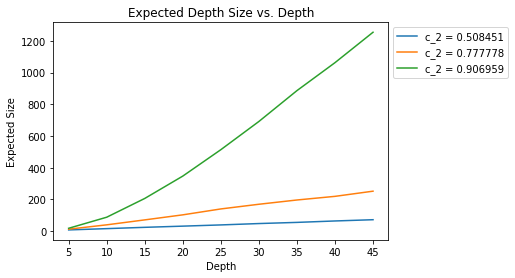

In [7]:
# Is the expected growth linear regardless of the alphabet?
PROBS = [[0.2, 0.3, 0.1, 0.3], [0.5 for _ in range(4)], [0.5 for _ in range(8)]]
SAMPLES = 1000
LENGTH = [5 * i for i in range(1, 10)]

def plot_average_growth(probs, samples, lengths):
    c_2 = common_probs.get_arbitrary_c2(probs)
    samps = [sample_total_states(samples, probs, l)[0] for l in lengths]
    plt.plot(lengths, samps, label='c_2 = %f' % c_2)
    
for prob in PROBS:
    plot_average_growth(prob, SAMPLES, LENGTH)
plt.title('Expected Depth Size vs. Depth')
plt.ylabel('Expected Size')
plt.xlabel('Depth')
plt.legend(bbox_to_anchor=[1, 1])
plt.show()

One can see that there seems to be linear expected growth for a wide array of alphabet distributions.

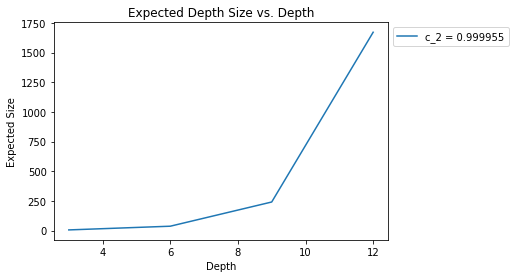

In [11]:
# Does the linear growth ever break? Yes.
plot_average_growth([0.9 for _ in range(6)], 1000, [3 * i for i in range(1, 5)])
plt.title('Expected Depth Size vs. Depth')
plt.ylabel('Expected Size')
plt.xlabel('Depth')
plt.legend(bbox_to_anchor=[1, 1])
plt.show()

However, it seems that there is not linear expected growth for all alphabet distributions. This is most likely because $\mu_W \geq 1$, which will make more sense after reading the next section.

In [9]:
# What is mu_W for the above?
probs = [0.9 for _ in range(6)]
length = 15

ds = DepthSampler(probs, length)
df = ds.draw_samples(100, ['threads', 'thread_children'])
total_offspring = df[df['depth'] == length - 1]['thread_children'].map(sum).sum()
num_threads = df[df['depth'] == length - 1]['threads'].sum()
mu_w = total_offspring / num_threads
print mu_w

1.83924172905


# Derivation of Approximation

First consider the notion of what I have been referring to as a "thread". A thread is a path of failures, starting at the root state, moving from lower depth to higher depth, and composed of at least two failure edges. This structure is important because it represents a particular running suffix matching with a prefix. (Note that if the path consisted of only one edge the suffix would be the empty string which we don't count).

Let $Z_n$ be the number of states in depth $n$ with a failure going to a state besides the root. Therefore, $Z_n$ is at most one less than the true number of states in the depth. In this way we are really counting the number of running threads there are within the DFA. Another way to think of this is that we are keeping track of the running suffixes that match with prefixes.

Now consider said threads for depth $n$; we can group these into two categories. The first is that the thread was extended from a pre-existing thread in the previous depth. The second is that the thread was just created at this depth. There can be at most one state in this second case because the failure will point back to depth 1, and all such states that do this will be merged together.

Taking these concepts we can form the following relation...

$$
Z_{n + 1} = X_{n + 1} + \sum_{i = 1}^{Z_n} Y_{i, n}
$$

Here $X_{n + 1}$ takes the value 0 or 1 and represents the second case. The random variables $Y_{i, n}$ represent the first case, and can be thought of as the offspring distribution for thread $i$ in the last depth. One inconvenience is that states may have shared offspring because of merging. It is important that $\sum_{i = 1}^{Z_n} Y_{i, n}$ counts each offspring only once, and therefore, $Y_{i, n}$ is not very well defined. To remedy this, we can introduce $W_n$ to be the average offspring of each state. Then,

$$
Z_{n + 1} = X_{n + 1} + Z_n W_n
$$

Note that $W_n = \frac{Z_{n + 1} - X_{n + 1}}{Z_n}$.

### Example of Quantities


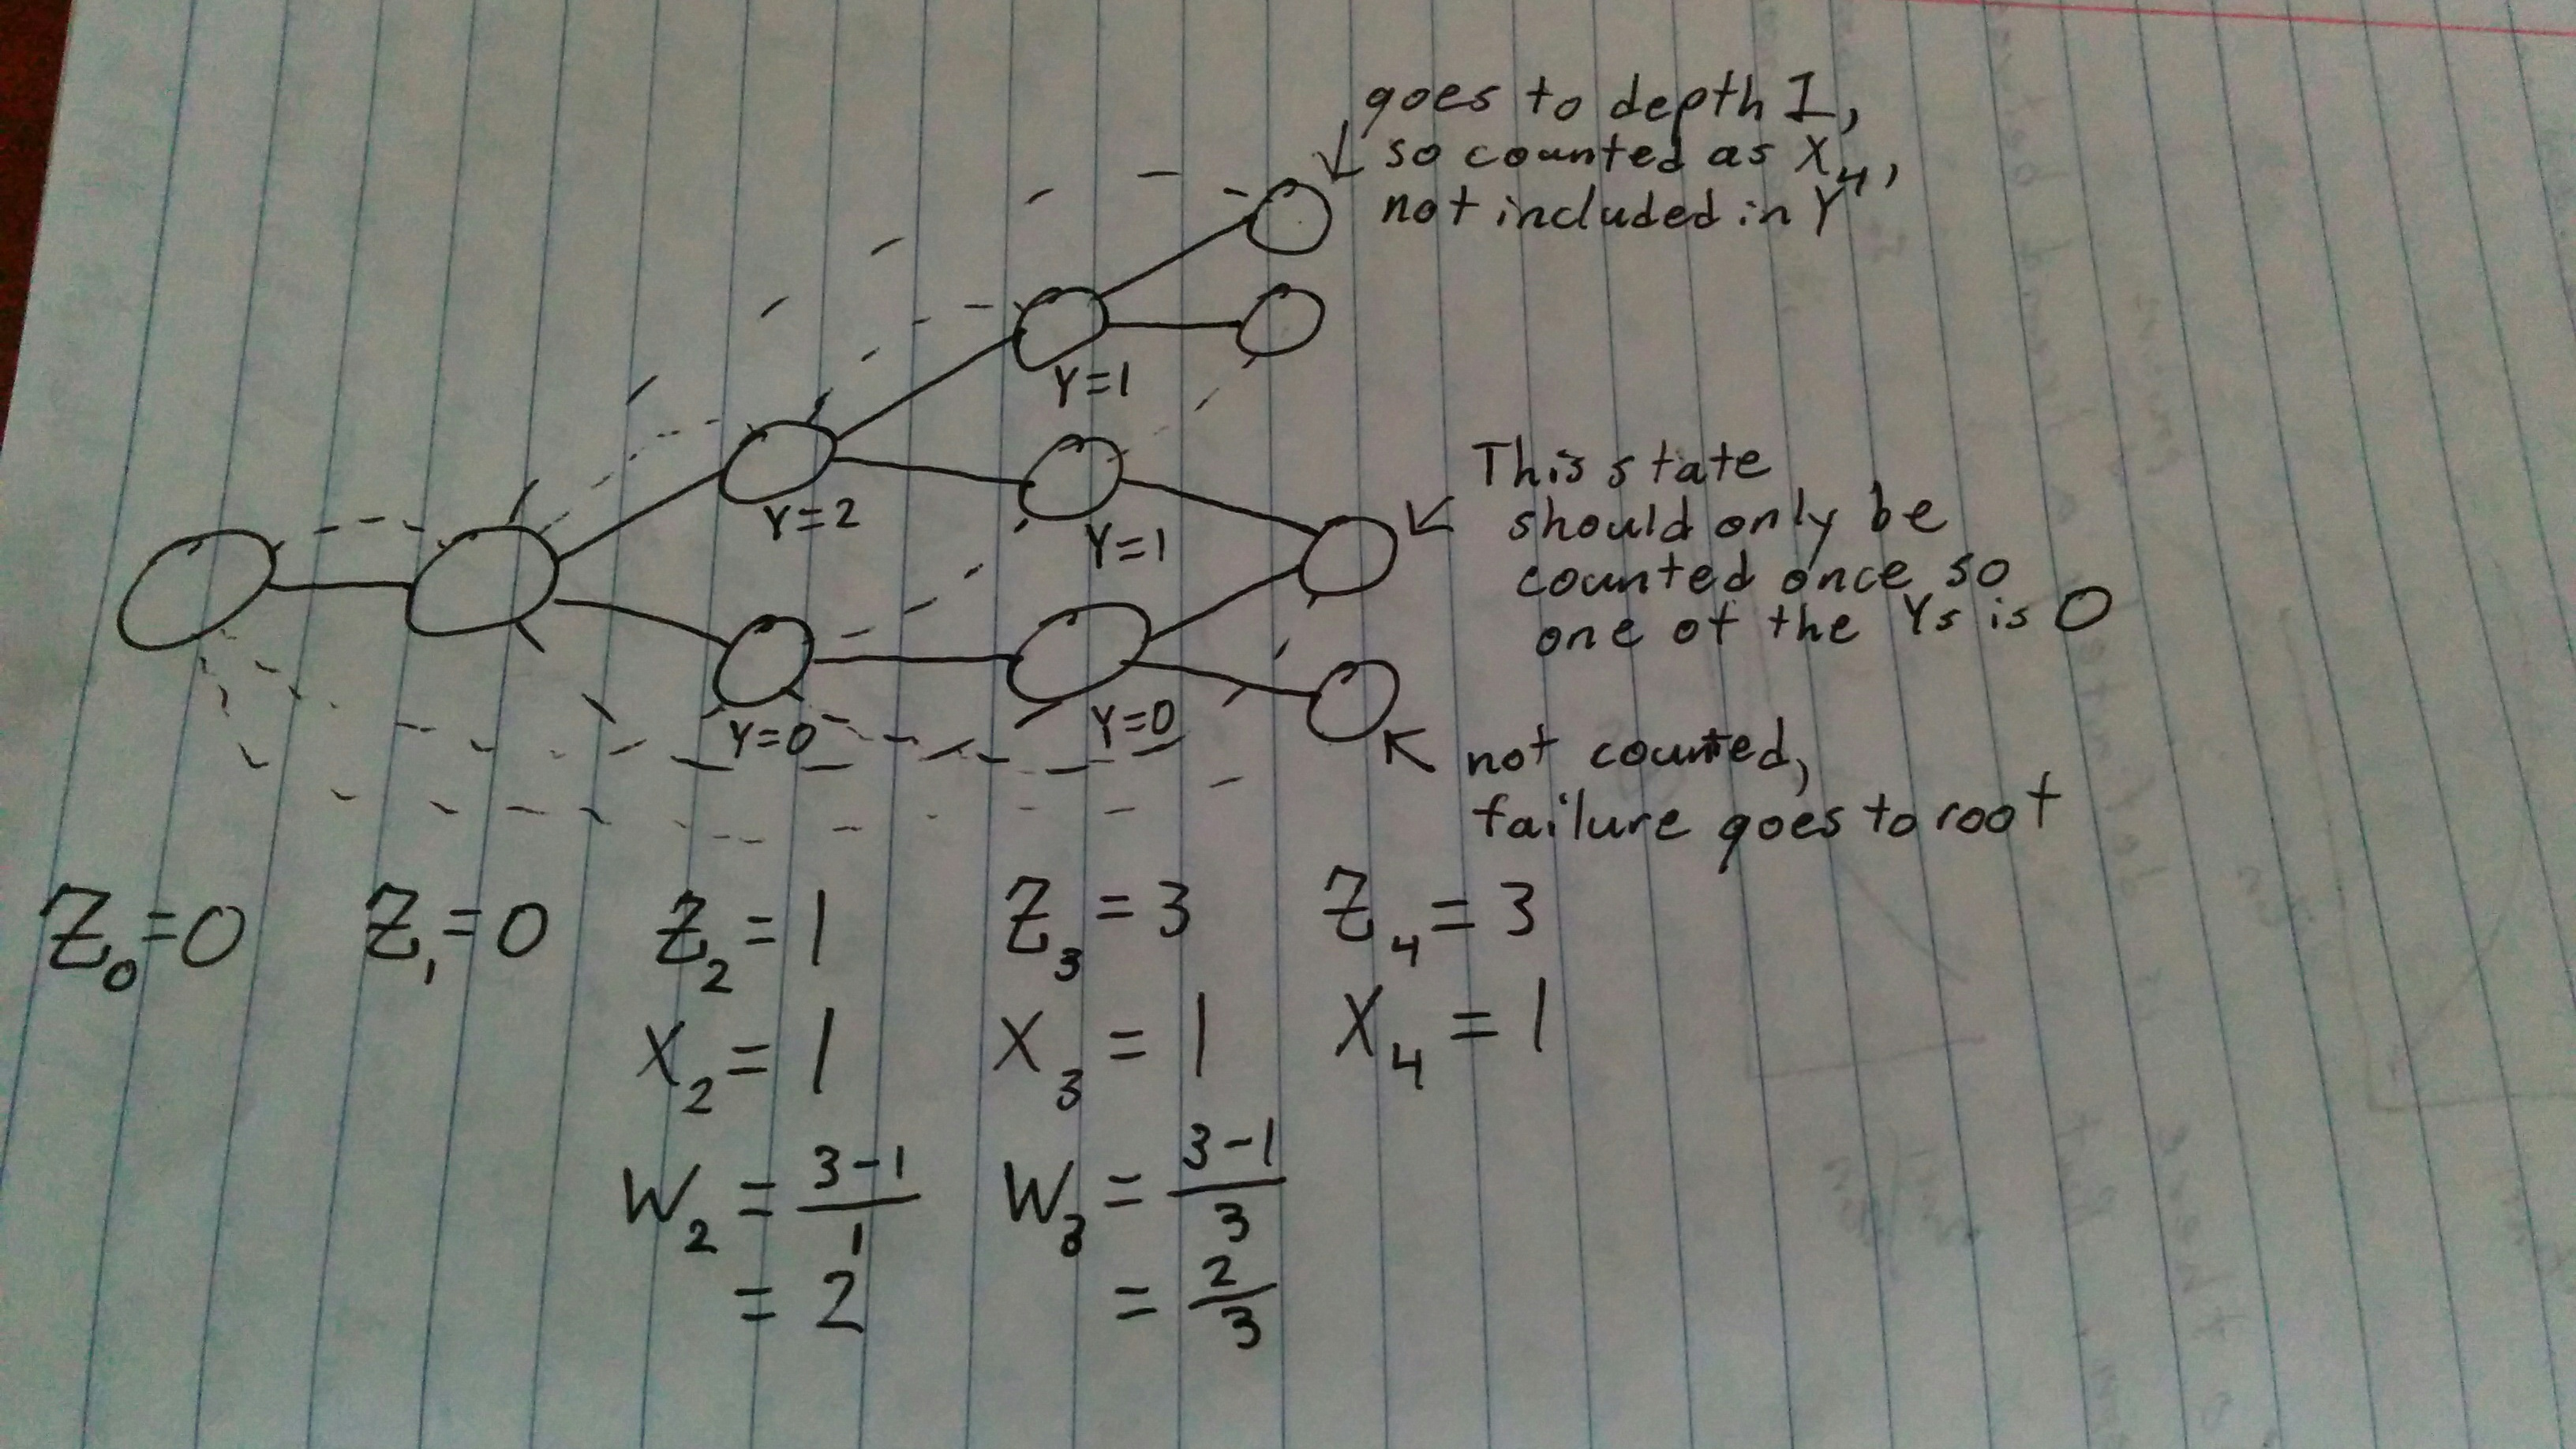

In [12]:
Image('img/approx_ex.jpg')


### The Assumptions

The following three assumptions are key to the following proof and will need to be justified.

1. $X_n$ and $Y_{i, n}$ (or $W_n$) converge in distribution.
2. The rate of convergence for the above sequence of random variables converges at an appropriate speed and depends only on the alphabet distribution (e.g. the letter A shows up with 0.5 probability), not on the length of the generalized string.
3. $Y_{i, n}$ (or $W_n$) is negatively correlated with $Z_n$.

I have simulation evidence that supports each of these assumptions, proving them is the hard part.

### The Approximation

Now to derive the approximation...

$$
E[Z_{n + 1}] = E[X_{n + 1}] + E[W_n Z_n]
$$

Using assumption three, we can create an upper bound...

$$
E[Z_{n + 1}] \leq E[X_{n + 1}] + E[W_n] E[Z_n]
$$

We can iteratively apply this upper bound to get...

$$
E[Z_{n + 1}] \leq E[X_{n + 1}] + E[W_n] \left(E[X_n] + E[W_{n - 1}] (\ldots)\right)
$$

By assumption 1, $E[X_n] \rightarrow \mu_X$ and $E[W_n] \rightarrow \mu_W$. These constants can be used in place for each expected value in the above equation; however, when we are at low depths, the expected value may be far away from these constants. Therefore, we must also introduce some $\delta_n$, the error for using this substitution at depth $n$.

$$
E[Z_{n + 1}] \leq \mu_X \sum_{j = 0}^n \mu_W^j + \sum_{j = 0}^n \delta_n
$$

From assumption 2, $\sum_{j = 0}^n \delta_n$ will converge to a constant amonut of error, $E$, as $n \rightarrow \infty$. Thus, if $\mu_W < 1$...

$$
M := \lim_{n \rightarrow \infty} E[Z_n] = \frac{\mu_X}{1 - \mu_W} + E
$$

And finally we see that the total number of states is bounded by $Mn$. Since $M$ only depended on the alphabet distribution, the expected total number of states grows linearly.

## Evaluation of Approximation

To see how close this approximation is, I found estimates $\hat{\mu}_X$ and $\hat{\mu}_W$. Using these, I made a plot of of $\frac{\hat{\mu}_X}{1 - \hat{\mu}_W} + 1$ (plus one because we are considereing all states not just the ones counted by $Z_n$) against the average size vs depth. 

mu_x = 0.638500
mu_w = 0.880685
mu_x/(1-mu_w) + 1 = 6.351400


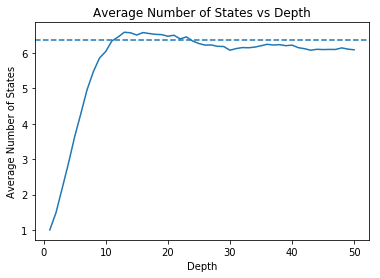

In [16]:
PROBS = [0.5 for _ in range(4)]
LENGTH = 50
SAMPLES = 10000

def sample(probs, length, num_samples):
    ds = DepthSampler(probs, length)
    return ds.draw_samples(num_samples, ['states', 'threads', 'thread_children', 'new_thread'])

def compute_upperbound(df, length):
    mu_x = df[df['depth'] == length - 1]['new_thread'].mean()
    print 'mu_x = %f' % mu_x
    total_offspring = df[df['depth'] == length - 1]['thread_children'].map(sum).sum()
    num_threads = df[df['depth'] == length - 1]['threads'].sum()
    mu_w = total_offspring / num_threads
    print 'mu_w = %f' % mu_w
    return (mu_x / (1 - mu_w)) + 1

df = sample(PROBS, LENGTH, SAMPLES)
states = df.groupby('depth')['states'].mean().tolist()[1:]
depths = range(1, LENGTH + 1)
plt.plot(depths, states)
upper = compute_upperbound(df, LENGTH)
print 'mu_x/(1-mu_w) + 1 = %f' % upper
plt.axhline(upper, ls='--')
plt.xlabel('Depth')
plt.ylabel('Average Number of States')
plt.title('Average Number of States vs Depth')
plt.show()

While the dotted line above is not an upper bound for the whole average number of states found, we did not necessarily expect it to be because we are missing the error term, E. That being said, it does seem to be an upper bound to the average number of states once we start converging.

# Addressing the Assumptions

## Assumption 1: Convergence in Distribution

First we realize it is really only imperative that $W_n$ converges in distribution because we can make an upper bound by setting $X_n = 1$ for all $n$. Therefore, much of the effort will be put on looking at $W_n$.

Heuristically speaking, it makes sense that $X_n$ and $W_n$ should converge in distribution. This is because the probability of having at least one k length suffix match with a prefix is $c_2^k$ in most cases. Thus, at some point having a large suffix match with a prefix becomes unlikely and it does not matter how far into the generalized string we look (see below for more detail).

Making plots of the $\hat{\mu}_X$ and $\hat{\mu}_W$, we see that the simulations back up these heuristics. ($X_n$ is plot on the left, $W_n$ is plot on the right).

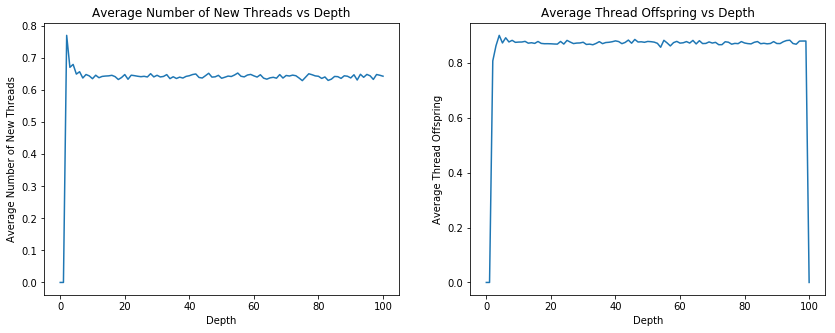

In [24]:
def sample(probs, length, samples):
    ds = DepthSampler(probs, length)
    return ds.draw_samples(samples, ['threads', 'thread_children', 'new_thread', 'merge_degree'])

def plot_average_new_thread_by_depth(df, length, posn):
    depths = range(length + 1)
    new_thread_trend = df.groupby('depth')['new_thread'].mean().tolist()
    plt.subplot(posn)
    plt.plot(depths, new_thread_trend)
    plt.xlabel('Depth')
    plt.ylabel('Average Number of New Threads')
    plt.title('Average Number of New Threads vs Depth')
    
def plot_average_offspring_by_depth(df, length, posn):
    depths = range(length + 1)
    cpy = df
    cpy['mean_thread_children'] = (cpy['thread_children']
                                  .map(lambda l: 0 if len(l) == 0 else sum(l) / len(l)))
    offspring_trend = cpy.groupby('depth')['mean_thread_children'].mean().tolist()
    plt.subplot(posn)
    plt.plot(depths, offspring_trend)
    plt.xlabel('Depth')
    plt.ylabel('Average Thread Offspring')
    plt.title('Average Thread Offspring vs Depth')

probs = [0.5 for _ in range(4)]
length = 100
samples = 10000
df = sample(probs, length, samples)
plt.figure(1, figsize=(14, 5))
plot_average_new_thread_by_depth(df, length, 121)
plot_average_offspring_by_depth(df, length, 122)
plt.show()

From these simulations, it appears that the averages are stabilizing, which is the main thing that is being used in the proof. However, we need the constant these averages (really just $W_n$ as stated before) converge to to be the same regardless of of the size of the generalized string. This appears to be the case as shown by the plot below. 

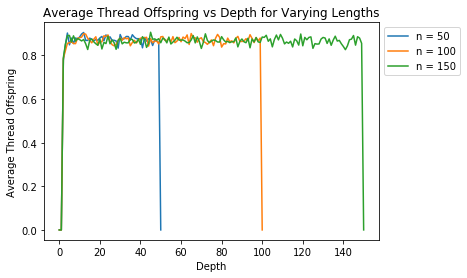

In [5]:
# Find out if the offspring distribution changes with longer strings.

PROBS = [0.5 for _ in range(4)]

def plot_average_offspring_by_depth(samples, lengths):
    for length in lengths:
        depths = range(length + 1)
        ds = DepthSampler(PROBS, length)
        df = ds.draw_samples(samples, ['thread_children'])
        df['mean_thread_children'] = (df['thread_children']
                                      .map(lambda l: 0 if len(l) == 0 else sum(l) / len(l)))
        offspring_trend = df.groupby('depth')['mean_thread_children'].mean().tolist()
        plt.plot(depths, offspring_trend, label='n = %d' % length)
    plt.xlabel('Depth')
    plt.ylabel('Average Thread Offspring')
    plt.title('Average Thread Offspring vs Depth for Varying Lengths')
    plt.legend(bbox_to_anchor=[1, 1])
    plt.show()
    
plot_average_offspring_by_depth(1000, [50, 100, 150])

### Justification 1

The following is a heursitic that could hopefully guide a proof. Instead of considering $W_n$, let's instead consider a proxy. Let $A_n$ be the length of the longest suffix that is also a prefix for some randomly picked string in the general string at depth $n$. It is much easier to see that $A_n$ converges in distribution than $W_n$. Although as $n$ increases $A_n$ has the possibility of taking on larger values, these large values are unlikely. In fact,

$$
P(A_n = k) \approx c_2^k
$$

Therefore, every time $n$ increases, the distribution of $A_n$ is being changed by an exponentially small amount, implying that we are converging in distribution to some $A$. This implies to us that $W_n$ might converge in distribution because it relies on the probabilities of largest suffixes matching with prefixes. In particular, if $A_n$ and $A_{n + 1}$ were known, $W_n$ would become deterministic because we would be able to calculate the exact number of states present at depths $n$ and $n + 1$ and therefore calculate the average offspring.

Note that if we could prove something this way, it would also solve the problem with assumption 2 because the convergence seems to only rely on $c_2$, and we are converging exponentially fast.

#### Justification 1 Part 2

I think that for the same reasons that $A_n$ converges in distribution, it would be not bad to show that $Z_n$ converges in distribution. As noted before, $W_n \approx \frac{Z_{n + 1}}{Z_n}$. Can we say something about this? I know that Slutsky's theorem only applies if we are converging in probability to a constant, but here we have the same sequence of random variables.

### Justification 2

Another approach that I took to justifying assumption 1 was based on the idea that the signature size converges in distribution. To recall, the signature of a state is the depths one visits as you traceback through the failures. In a previous email that you sent me, you proved that the distribution of the size of the signature converges in distribution.

Heuristically, it stands to reason that if the size of the signature is fixed, the offspring distribution is fixed. Why is this? Let's say that the signature is fixed at a size of 3 e.g. $(0, a, b)$. The possible child signatures from this is $(0), (0, 1), (0, 1, a + 1), (0, a + 1), ...$ The important thing to notice is that it is not important what $a$ or $b$ is. What determines if $1$, $a + 1$, or $b + 1$ is present is what appears in the letter set immediately after positions $a$ and $b$.

Where this falls apart is that this does not explain why the amount of merging would converge. However, the simulations below seem to show that, if merging is accounted for, we still stabalize.

In [2]:
# Test to see if offspring distribution is the same as long as the signature size is the same.
PROBS = [0.5 for _ in range(4)]
ss = SignatureSampler(PROBS, 30, [4])
df = ss.draw_samples(10000, ['offspring'])

In [3]:
df.groupby('signature').mean().head()

,offspring
signature,
"(0, 1, 2, 3)",2.124135
"(0, 1, 2, 4)",2.211382
"(0, 1, 2, 5)",2.155224
"(0, 1, 2, 6)",2.135632
"(0, 1, 2, 7)",2.091623


In [4]:
# Test to see if offspring distribution is the same as long as the signature size is the same.
PROBS = [0.2, 0.3, 0.6, 0.4]
ss = SignatureSampler(PROBS, 30, [3])
df = ss.draw_samples(10000, ['offspring'])

In [5]:
df.groupby('signature').mean().head()

,offspring
signature,
"(0, 1, 2)",1.728787
"(0, 1, 3)",1.732020
"(0, 1, 4)",1.728502
"(0, 1, 5)",1.750449
"(0, 1, 6)",1.802395


As one can see, the average offsprings are about the same in two different cases for fixed signature size. I think a lot of the variance can be attributed to the signatures lower on the list having less samples because they occur less often. While this suggests this is a promising direction for proving things, justifying why the merging distribution should be the same for fixed signature size is not apparent.

## Assumption 2: Convergence Rate


See justification 1, above.

## Assumption 3: Negative Correlation

To start with, we noted that $W_n = \frac{Z_{n + 1} - X_{n + 1}}{Z_n}$, so it is apparent that if $Z_n$ does not affect $Z_{n + 1}$ the relationship is obviously negative. This is very unlikely however, and the first plot below shows that this is false.

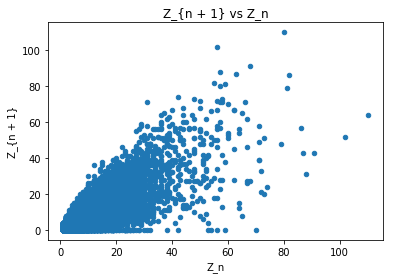

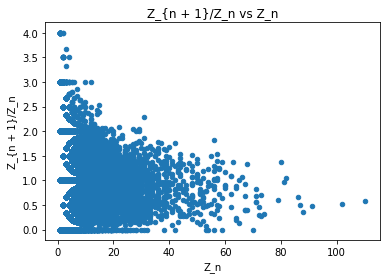

In [18]:
# Is growth ratio affected by the size of the current depth?
PROBS = [0.5 for _ in xrange(4)]
LENGTH = 50
NUM_SAMPLES = 1000

ds = DepthSampler(PROBS, LENGTH)
df = ds.draw_samples(NUM_SAMPLES, ['states', 'growth_ratio'])
df['nxt'] = df['states'] * df['growth_ratio']

df.plot.scatter('states', 'nxt')
plt.xlabel(r'Z_n')
plt.ylabel(r'Z_{n + 1}')
plt.title(r'Z_{n + 1} vs Z_n')

df.plot.scatter('states', 'growth_ratio')
plt.xlabel(r'Z_n')
plt.ylabel('Z_{n + 1}/Z_n')
plt.title(r'Z_{n + 1}/Z_n vs Z_n')
plt.show()

As one would expect, there is clearly a trend between how many states are in the current depth and how many offspring will be produced in the next state. However, the second plot shows that the correlation between $W_n$ and $Z_n$ should be negative. Why is this the case heuristically? There are only so many signatures that can be present in the next depth. Therefore, if there are a lot of states in the current depth we will most likely have a lot of merging and there will be less offspring per parent. Proving negative correlation seems challenging, however, and I am not aware of a good approach.